## ETL Process Outline Using Python

### 1. Install Required Libraries

In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


### 2. Extract Data from VCF Files

In [2]:
!gunzip clinvar.vcf.gz


## ETL Pipeline for clinvar.vcf (Variant Call Format)

#### ✅ Step 1: Extract

In [7]:
def extract_variants_stream(vcf_path):
    with open(vcf_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue

            cols = line.strip().split('\t')
            if len(cols) < 8:
                continue

            yield {
                'chrom': cols[0],
                'pos': int(cols[1]),
                'id': cols[2],
                'ref': cols[3],
                'alt': cols[4],
                'qual': cols[5],
                'filter': cols[6],
                'info': cols[7]
            }

# Example: Just count number of variants
count = 0
for _ in extract_variants_stream('clinvar.vcf/clinvar.vcf'):
    count += 1

print(f"Total variants: {count}")


Total variants: 3378061


## 3 Transform

### 🧪 Step 1: Parse the INFO field

In [11]:
def parse_info_field(info_str):
    info_dict = {}
    for item in info_str.split(';'):
        if '=' in item:
            key, value = item.split('=', 1)
            info_dict[key] = value
        else:
            info_dict[item] = True  # flag-style fields
    return info_dict


### 🧬 Step 2: Transform and Print Important Info
Let’s extract only useful fields like clinical significance (CLNSIG) and disease name (CLNDN):

In [15]:
for variant in extract_variants_stream('clinvar.vcf/clinvar.vcf'):
    info = parse_info_field(variant['info'])

    print({
        'chrom': variant['chrom'],
        'pos': variant['pos'],
        'ref': variant['ref'],
        'alt': variant['alt'],
        'clinical_significance': info.get('CLNSIG', 'NA'),
        'disease_name': info.get('CLNDN', 'NA')
    })
    break  # remove this later to process all


{'chrom': '1', 'pos': 66926, 'ref': 'AG', 'alt': 'A', 'clinical_significance': 'Uncertain_significance', 'disease_name': 'Retinitis_pigmentosa'}


## Load 

Save to CSV (Simple, Universally Readable)

In [19]:
import csv

def save_variants_to_csv(vcf_path, output_path):
    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=[
            'chrom', 'pos', 'ref', 'alt', 'clinical_significance', 'disease_name'
        ])
        writer.writeheader()

        for variant in extract_variants_stream(vcf_path):
            info = parse_info_field(variant['info'])
            writer.writerow({
                'chrom': variant['chrom'],
                'pos': variant['pos'],
                'ref': variant['ref'],
                'alt': variant['alt'],
                'clinical_significance': info.get('CLNSIG', 'NA'),
                'disease_name': info.get('CLNDN', 'NA')
            })

save_variants_to_csv('clinvar.vcf/clinvar.vcf', 'clinvar_variants.csv')


In [21]:
# Install Python PostgreSQL library
!pip install psycopg2 sqlalchemy pandas


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.2 MB ? eta -:--:--
   ------------------------------------ --- 1.0/1.2 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 1.6 MB/s eta 0:00:00


In [23]:
import pandas as pd

# Path to your large CSV file
csv_file = "clinvar_variants.csv"

# Dictionary to accumulate the results
agg_data = {}

# Read in chunks
chunksize = 10000  # Adjust based on your RAM
for chunk in pd.read_csv(csv_file, chunksize=chunksize):

    # Group and aggregate
    grouped = chunk.groupby('clinical_significance').agg(
        total_variants=('chrom', 'count'),
        unique_diseases=('disease_name', 'nunique')
    )

    # Accumulate
    for idx, row in grouped.iterrows():
        if idx not in agg_data:
            agg_data[idx] = {
                'total_variants': row['total_variants'],
                'unique_diseases': row['unique_diseases']
            }
        else:
            agg_data[idx]['total_variants'] += row['total_variants']
            agg_data[idx]['unique_diseases'] += row['unique_diseases']  # Note: this is an approximation!

# Convert to final DataFrame
final_summary = pd.DataFrame([
    {'clinical_significance': key,
     'total_variants': val['total_variants'],
     'unique_diseases': val['unique_diseases']}
    for key, val in agg_data.items()
])

# Display or export
print(final_summary)
final_summary.to_csv("olap_summary.csv", index=False)


                                clinical_significance  total_variants  \
0                                              Benign          209658   
1                                Benign/Likely_benign           53052   
2        Conflicting_classifications_of_pathogenicity          140883   
3                                       Likely_benign          977784   
4                                   Likely_pathogenic           99004   
..                                                ...             ...   
86        Pathogenic/Pathogenic,_low_penetrance|other               1   
87           Pathogenic/Likely_pathogenic|association               1   
88                         Benign|confers_sensitivity               1   
89  Conflicting_classifications_of_pathogenicity|o...               2   
90                          confers_sensitivity|other               1   

    unique_diseases  
0             30616  
1             31085  
2             69345  
3             44803  
4            

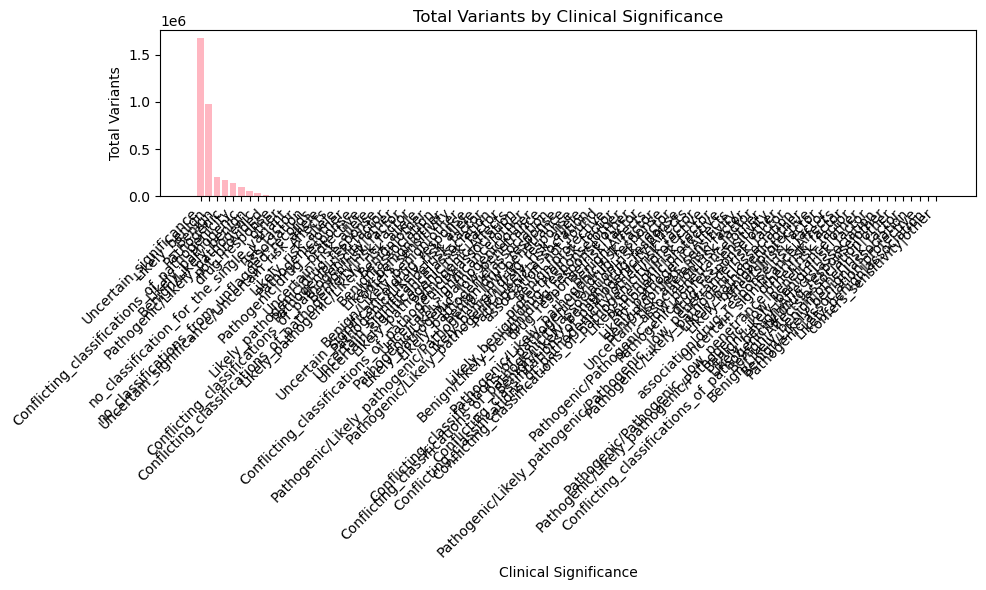

In [25]:
import matplotlib.pyplot as plt

final_summary.sort_values('total_variants', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(final_summary['clinical_significance'], final_summary['total_variants'], color='lightpink')
plt.xticks(rotation=45, ha='right')
plt.title("Total Variants by Clinical Significance")
plt.xlabel("Clinical Significance")
plt.ylabel("Total Variants")
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

chunksize = 100_000
i = 0

for chunk in pd.read_csv("clinvar_variants.csv", chunksize=chunksize):
    chunk.to_csv(f"variants_part_{i}.csv", index=False)
    print(f"Saved: variants_part_{i}.csv")
    i += 1


Saved: variants_part_0.csv
Saved: variants_part_1.csv
Saved: variants_part_2.csv
Saved: variants_part_3.csv
Saved: variants_part_4.csv
Saved: variants_part_5.csv
Saved: variants_part_6.csv
Saved: variants_part_7.csv
Saved: variants_part_8.csv
Saved: variants_part_9.csv
Saved: variants_part_10.csv
Saved: variants_part_11.csv
Saved: variants_part_12.csv
Saved: variants_part_13.csv
Saved: variants_part_14.csv
Saved: variants_part_15.csv
Saved: variants_part_16.csv
Saved: variants_part_17.csv
Saved: variants_part_18.csv
Saved: variants_part_19.csv
Saved: variants_part_20.csv
Saved: variants_part_21.csv
Saved: variants_part_22.csv
Saved: variants_part_23.csv
Saved: variants_part_24.csv
Saved: variants_part_25.csv
Saved: variants_part_26.csv
Saved: variants_part_27.csv
Saved: variants_part_28.csv
Saved: variants_part_29.csv
Saved: variants_part_30.csv
Saved: variants_part_31.csv
Saved: variants_part_32.csv
Saved: variants_part_33.csv


##  OLAP 

### 1. Explore the Data

###  2. Clean the Data (if needed)

### 3. OLAP-like Questions to Answer

a. 🔬 How many variants per chromosome?

b. ⚠️ Most common diseases?

c. 📊 Pathogenic vs Benign variants?

### 4. Pivot Table (OLAP Cube Style)

### 5. Visualizations (Optional)

In [31]:
!pip install matplotlib

In [33]:
import pandas as pd

# Loop through each file
for i in range(33):
    filename = f"variants_part_{i}.csv"
    try:
        df = pd.read_csv(filename)

        not_specified_count = (df['disease_name'] == 'not_specified').sum()
        not_provided_count = (df['disease_name'] == 'not_provided').sum()
        total_rows = len(df)
        combined = not_specified_count + not_provided_count

        print(f"\n📄 File: {filename}")
        print(f"Total rows: {total_rows}")
        print(f"'not specified': {not_specified_count} rows ({not_specified_count / total_rows:.2%})")
        print(f"'not provided': {not_provided_count} rows ({not_provided_count / total_rows:.2%})")
        print(f"Combined: {combined} rows ({combined / total_rows:.2%})")

    except Exception as e:
        print(f"\n⚠️ Error processing file {filename}: {e}")



📄 File: variants_part_0.csv
Total rows: 100000
'not specified': 22945 rows (22.95%)
'not provided': 27223 rows (27.22%)
Combined: 50168 rows (50.17%)

📄 File: variants_part_1.csv
Total rows: 100000
'not specified': 24276 rows (24.28%)
'not provided': 28262 rows (28.26%)
Combined: 52538 rows (52.54%)

📄 File: variants_part_2.csv
Total rows: 100000
'not specified': 19821 rows (19.82%)
'not provided': 28978 rows (28.98%)
Combined: 48799 rows (48.80%)

📄 File: variants_part_3.csv
Total rows: 100000
'not specified': 11141 rows (11.14%)
'not provided': 23058 rows (23.06%)
Combined: 34199 rows (34.20%)

📄 File: variants_part_4.csv
Total rows: 100000
'not specified': 16925 rows (16.93%)
'not provided': 24037 rows (24.04%)
Combined: 40962 rows (40.96%)

📄 File: variants_part_5.csv
Total rows: 100000
'not specified': 11887 rows (11.89%)
'not provided': 24835 rows (24.83%)
Combined: 36722 rows (36.72%)

📄 File: variants_part_6.csv
Total rows: 100000
'not specified': 17337 rows (17.34%)
'not prov

In [35]:
!pip install scikit-learn


In [37]:

import pandas as pd
df = pd.read_csv('variants_part_0.csv')

print("Data shape:", df.shape)
print("Unique diseases:", df['disease_name'].nunique())



Data shape: (100000, 6)
Unique diseases: 5657


In [40]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

for i in range(34):
    filename = f'variants_part_{i}.csv'
    output_filename = f'predicted_variants_part_{i}.csv'

    try:
        # Load CSV
        df = pd.read_csv(filename)

        # Clean disease_name
        df['disease_name'] = df['disease_name'].fillna('').str.strip()

        # Step 1: Handle partial/mixed unknown values (e.g., 'not_specified|SomeDisease')
        def clean_partial_disease(name):
            if 'not_provided' in name or 'not_specified' in name:
                # Split and remove unwanted values
                parts = [part.strip() for part in name.split('|') if part not in ['not_provided', 'not_specified']]
                return '|'.join(parts) if parts else 'unknown'
            return name

        df['disease_name'] = df['disease_name'].apply(clean_partial_disease)

        # Step 2: Define features and target
        features = ['clinical_significance']
        target = 'disease_name'

        # Step 3: Keep only common diseases (ignore rare ones)
        counts = df['disease_name'].value_counts()
        common_diseases = counts[counts > 20].index
        df = df[df['disease_name'].isin(common_diseases) | (df['disease_name'] == 'unknown')]

        # Step 4: Split known vs unknown
        known_df = df[df['disease_name'] != 'unknown']
        unknown_df = df[df['disease_name'] == 'unknown']

        if known_df.empty or unknown_df.empty:
            print(f"⚠️ Skipping {filename}: insufficient known or unknown data.")
            continue

        # Step 5: Encode features and target
        X = pd.get_dummies(known_df[features])
        le = LabelEncoder()
        y = le.fit_transform(known_df[target])

        # Step 6: Train Random Forest model
        model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
        model.fit(X, y)

        # Step 7: Predict unknown values
        X_unknown = pd.get_dummies(unknown_df[features])
        X_unknown = X_unknown.reindex(columns=X.columns, fill_value=0)
        predicted = model.predict(X_unknown)
        predicted_names = le.inverse_transform(predicted)

        # Step 8: Update original dataframe with predictions
        df_updated = df.copy()
        df_updated.loc[df_updated['disease_name'] == 'unknown', 'disease_name'] = predicted_names

        # Step 9: Save updated CSV
        df_updated.to_csv(output_filename, index=False)
        print(f"✅ File saved: {output_filename}")

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")


✅ File saved: predicted_variants_part_0.csv
✅ File saved: predicted_variants_part_1.csv
✅ File saved: predicted_variants_part_2.csv
✅ File saved: predicted_variants_part_3.csv
✅ File saved: predicted_variants_part_4.csv
✅ File saved: predicted_variants_part_5.csv
✅ File saved: predicted_variants_part_6.csv
✅ File saved: predicted_variants_part_7.csv
✅ File saved: predicted_variants_part_8.csv
✅ File saved: predicted_variants_part_9.csv
✅ File saved: predicted_variants_part_10.csv
✅ File saved: predicted_variants_part_11.csv
✅ File saved: predicted_variants_part_12.csv
✅ File saved: predicted_variants_part_13.csv
✅ File saved: predicted_variants_part_14.csv
✅ File saved: predicted_variants_part_15.csv
✅ File saved: predicted_variants_part_16.csv
✅ File saved: predicted_variants_part_17.csv
✅ File saved: predicted_variants_part_18.csv
✅ File saved: predicted_variants_part_19.csv
✅ File saved: predicted_variants_part_20.csv
✅ File saved: predicted_variants_part_21.csv
✅ File saved: predic

In [42]:
import pandas as pd

for i in range(34):
    filename = f"predicted_variants_part_{i}.csv"
    try:
        df = pd.read_csv(filename)
        total_rows = len(df)

        # Count exact matches
        exact_not_specified = (df['disease_name'] == 'not_specified').sum()
        exact_not_provided = (df['disease_name'] == 'not_provided').sum()
        exact_both = (df['disease_name'] == 'not_specified|not_provided').sum()

        # Rows that contain not_specified and/or not_provided anywhere (even mixed with others)
        contains_not_specified = df['disease_name'].str.contains(r'\bnot_specified\b', na=False)
        contains_not_provided = df['disease_name'].str.contains(r'\bnot_provided\b', na=False)

        mixed_cases = contains_not_specified | contains_not_provided
        total_mixed = mixed_cases.sum()

        # Breakdown of mixed (excluding exact matches)
        mixed_only = total_mixed - (exact_not_specified + exact_not_provided + exact_both)

        print(f"\n📄 File: {filename}")
        print(f"Total rows: {total_rows}")
        print(f"Exact 'not_specified': {exact_not_specified} rows ({exact_not_specified / total_rows:.2%})")
        print(f"Exact 'not_provided': {exact_not_provided} rows ({exact_not_provided / total_rows:.2%})")
        print(f"Exact 'not_specified|not_provided': {exact_both} rows ({exact_both / total_rows:.2%})")
        print(f"Mixed (not exact): {mixed_only} rows ({mixed_only / total_rows:.2%})")
        print(f"Combined (any appearance): {total_mixed} rows ({total_mixed / total_rows:.2%})")

    except Exception as e:
        print(f"\n⚠️ Error processing file {filename}: {e}")



📄 File: predicted_variants_part_0.csv
Total rows: 92403
Exact 'not_specified': 0 rows (0.00%)
Exact 'not_provided': 0 rows (0.00%)
Exact 'not_specified|not_provided': 0 rows (0.00%)
Mixed (not exact): 0 rows (0.00%)
Combined (any appearance): 0 rows (0.00%)

📄 File: predicted_variants_part_1.csv
Total rows: 91248
Exact 'not_specified': 0 rows (0.00%)
Exact 'not_provided': 0 rows (0.00%)
Exact 'not_specified|not_provided': 0 rows (0.00%)
Mixed (not exact): 0 rows (0.00%)
Combined (any appearance): 0 rows (0.00%)

📄 File: predicted_variants_part_2.csv
Total rows: 92004
Exact 'not_specified': 0 rows (0.00%)
Exact 'not_provided': 0 rows (0.00%)
Exact 'not_specified|not_provided': 0 rows (0.00%)
Mixed (not exact): 0 rows (0.00%)
Combined (any appearance): 0 rows (0.00%)

📄 File: predicted_variants_part_3.csv
Total rows: 91328
Exact 'not_specified': 0 rows (0.00%)
Exact 'not_provided': 0 rows (0.00%)
Exact 'not_specified|not_provided': 0 rows (0.00%)
Mixed (not exact): 0 rows (0.00%)
Combin

In [44]:
import pandas as pd
import hashlib

# Load your main data
df = pd.read_csv('predicted_variants_part_14.csv')
#df = df.fillna('')  # Fill NaNs for processing

# Generate a consistent hash for IDs
def generate_id(value):
    return hashlib.md5(str(value).encode()).hexdigest()[:8]

# ------------------- DIM_DISEASE -------------------
dim_disease = df[['disease_name']].drop_duplicates().reset_index(drop=True)
dim_disease['disease_id'] = dim_disease['disease_name'].apply(generate_id)

# ------------------- DIM_GENOME -------------------
dim_genome = df[['chrom', 'pos', 'ref', 'alt']].drop_duplicates().reset_index(drop=True)
dim_genome['genome_id'] = dim_genome.apply(lambda x: generate_id(f"{x.chrom}:{x.pos}:{x.ref}:{x.alt}"), axis=1)

# ------------------- DIM_CLINICAL -------------------
dim_clinical = df[['clinical_significance']].drop_duplicates().reset_index(drop=True)
dim_clinical['clinical_id'] = dim_clinical['clinical_significance'].apply(generate_id)

# ------------------- DIM_TIME (if available) -------------------
if 'date_reported' in df.columns:
    df['date_reported'] = pd.to_datetime(df['date_reported'], errors='coerce')
    dim_time = df[['date_reported']].drop_duplicates().dropna().reset_index(drop=True)
    dim_time['time_id'] = dim_time['date_reported'].astype(str).apply(generate_id)
else:
    dim_time = pd.DataFrame()


In [46]:
# Merge dimensions into fact
fact = df.merge(dim_disease, on='disease_name', how='left')
fact = fact.merge(dim_genome, on=['chrom', 'pos', 'ref', 'alt'], how='left')
fact = fact.merge(dim_clinical, on='clinical_significance', how='left')

if not dim_time.empty:
    fact = fact.merge(dim_time, on='date_reported', how='left')

# Generate unique row ID *after* all merges
def generate_id(row):
    row_string = '|'.join(str(x) for x in row.values)
    return hashlib.md5(row_string.encode()).hexdigest()[:8]

fact['id'] = fact.apply(generate_id, axis=1)

# Build final fact table
fact_table = fact[['id', 'disease_id', 'genome_id', 'clinical_id'] + (['time_id'] if 'time_id' in fact.columns else [])]
fact_table = fact_table.rename(columns={'id': 'variant_id'})


In [48]:
fact_table.to_csv("fact_variants.csv", index=False)
dim_disease.to_csv("dim_disease.csv", index=False)
dim_genome.to_csv("dim_genome.csv", index=False)
dim_clinical.to_csv("dim_clinical.csv", index=False)
#dim_time.to_csv("dim_time.csv", index=False)


In [50]:
!pip install streamlit

In [54]:
!pip install seaborn

In [ ]:
!streamlit run app.py